In [4]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)

import numpy as np
import pandas as pd
import QuantLib as ql
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.tseries.offsets import BDay

import scipy.interpolate
from scipy.optimize import newton, fmin_slsqp

from CurveDataFetcher import CurveDataFetcher 
from CurveInterpolator import GeneralCurveInterpolator 
from models.calibrate import (
    calibrate_ns_ols,
    calibrate_nss_ols,
    calibrate_bc_ols,
    calibrate_bc_augmented_ols,
    calibrate_diebold_li_ols,
    calibrate_mles_ols,
    calibrate_pca_yield_curve,
    calibrate_smith_wilson_ols,
)
from utils.utils import pydatetime_to_quantlib_date, quantlib_date_to_pydatetime
from models.nss import ZeroCouponCurve

import nest_asyncio
nest_asyncio.apply()

%load_ext autoreload
%autoreload 2

In [5]:
cusip_curve_builder = CurveDataFetcher(use_ust_issue_date=True, no_logs_plz=True)

In [106]:
as_of_date = datetime(2024, 8, 29)
quote_type = "bid"

curve_set_df = cusip_curve_builder.build_curve_set(
    as_of_date=as_of_date,
    sorted=True, 
    use_github=True,
    # use_public_dotcom=True, 
    include_off_the_run_number=True,
    market_cols_to_return=[f"{quote_type}_price", f"{quote_type}_yield"],
    calc_free_float=True,
)

# remove OTRs and first off the runs due to liquidity premium
filtered_curve_set_df = curve_set_df[(curve_set_df["rank"] != 0) & (curve_set_df["rank"] != 1)]

# remove TBills
filtered_curve_set_df = filtered_curve_set_df[filtered_curve_set_df["security_type"] != "Bill"]

# remove low free float bonds (< $8bn)
filtered_curve_set_df = filtered_curve_set_df[filtered_curve_set_df["free_float"] > 8000] 

# filter out bonds very close to maturity
filtered_curve_set_df = filtered_curve_set_df[filtered_curve_set_df["time_to_maturity"] >= 30/360] 
filtered_curve_set_df = filtered_curve_set_df.sort_values(by=["time_to_maturity"])

# remove CTDs (this is a TODO)
# filtered_curve_set_df = filtered_curve_set_df[filtered_curve_set_df["is_ctd"] == False] 

# remove cusips trading special in repo (this is a TODO)
# filtered_curve_set_df = filtered_curve_set_df[filtered_curve_set_df["is_trading_special"] == False] 

filtered_curve_set_df

Using SOMA Holdings Data As of 2024-08-28
Using STRIPping Data As of 2024-07-31 00:00:00


,cusip,security_type,auction_date,issue_date,maturity_date,time_to_maturity,int_rate,high_investment_rate,is_on_the_run,label,...,parValue,percentOutstanding,est_outstanding_amt,corpus_cusip,outstanding_amt,portion_unstripped_amt,portion_stripped_amt,reconstituted_amt,free_float,rank
51,91282CFN6,Note,2022-09-26,2022-09-30,2024-09-30,0.087671,4.250,NaN,False,"Sep 24s, 2-Year",...,0.000000e+00,NaN,NaN,912821JT3,4.298880e+10,42988801.6,0.000000e+00,0.0,42988.8016,22.0
170,9128282Y5,Note,2017-09-28,2017-10-02,2024-09-30,0.087671,2.125,NaN,False,"Sep 24s, 7-Year",...,9.983019e+09,0.321017,3.109810e+10,9128203Q8,3.148010e+10,31414500.0,6.560000e+07,0.0,21431.4811,82.0
111,912828YH7,Note,2019-09-25,2019-09-30,2024-09-30,0.087671,1.500,NaN,False,"Sep 24s, 5-Year",...,1.427716e+10,0.316574,4.509896e+10,912821CX1,4.525896e+10,45216960.0,4.200000e+07,0.0,30939.8039,57.0
75,91282CDB4,Note,2021-10-12,2021-10-15,2024-10-15,0.128767,0.625,NaN,False,"Oct 24s, 3-Year",...,4.364017e+09,0.069976,6.236404e+10,912821GN9,6.236404e+10,62330444.4,3.360000e+07,0.0,57966.4277,34.0
52,91282CFQ9,Note,2022-10-25,2022-10-31,2024-10-31,0.172603,4.375,NaN,False,"Oct 24s, 2-Year",...,0.000000e+00,NaN,NaN,912821JY2,4.199464e+10,41963280.8,3.136000e+07,0.0,41963.2808,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,912810TN8,Bond,2023-04-13,2023-04-17,2053-02-15,28.484932,3.625,NaN,False,"Feb 53s, 30-Year",...,9.367420e+09,0.141965,6.598403e+10,912803GP2,6.598403e+10,50170937.7,1.581309e+10,1534040.0,40803.5178,6.0
387,912810TR9,Bond,2023-07-13,2023-07-17,2053-05-15,28.728767,3.625,NaN,False,"May 53s, 30-Year",...,5.723292e+09,0.091437,6.259307e+10,912803GS6,6.259307e+10,39104686.8,2.348839e+10,2265540.0,33381.3949,5.0
388,912810TT5,Bond,2023-10-12,2023-10-16,2053-08-15,28.980822,4.125,NaN,False,"Aug 53s, 30-Year",...,8.606596e+09,0.120247,7.157430e+10,912803GU1,7.157430e+10,60802584.0,1.077172e+10,208800.0,52195.9878,4.0
389,912810TV0,Bond,2024-01-11,2024-01-16,2053-11-15,29.232877,4.750,NaN,False,"Nov 53s, 30-Year",...,4.567153e+08,0.006874,6.644364e+10,912803GW7,6.644364e+10,57766113.9,8.677531e+09,1851960.0,57309.3986,3.0


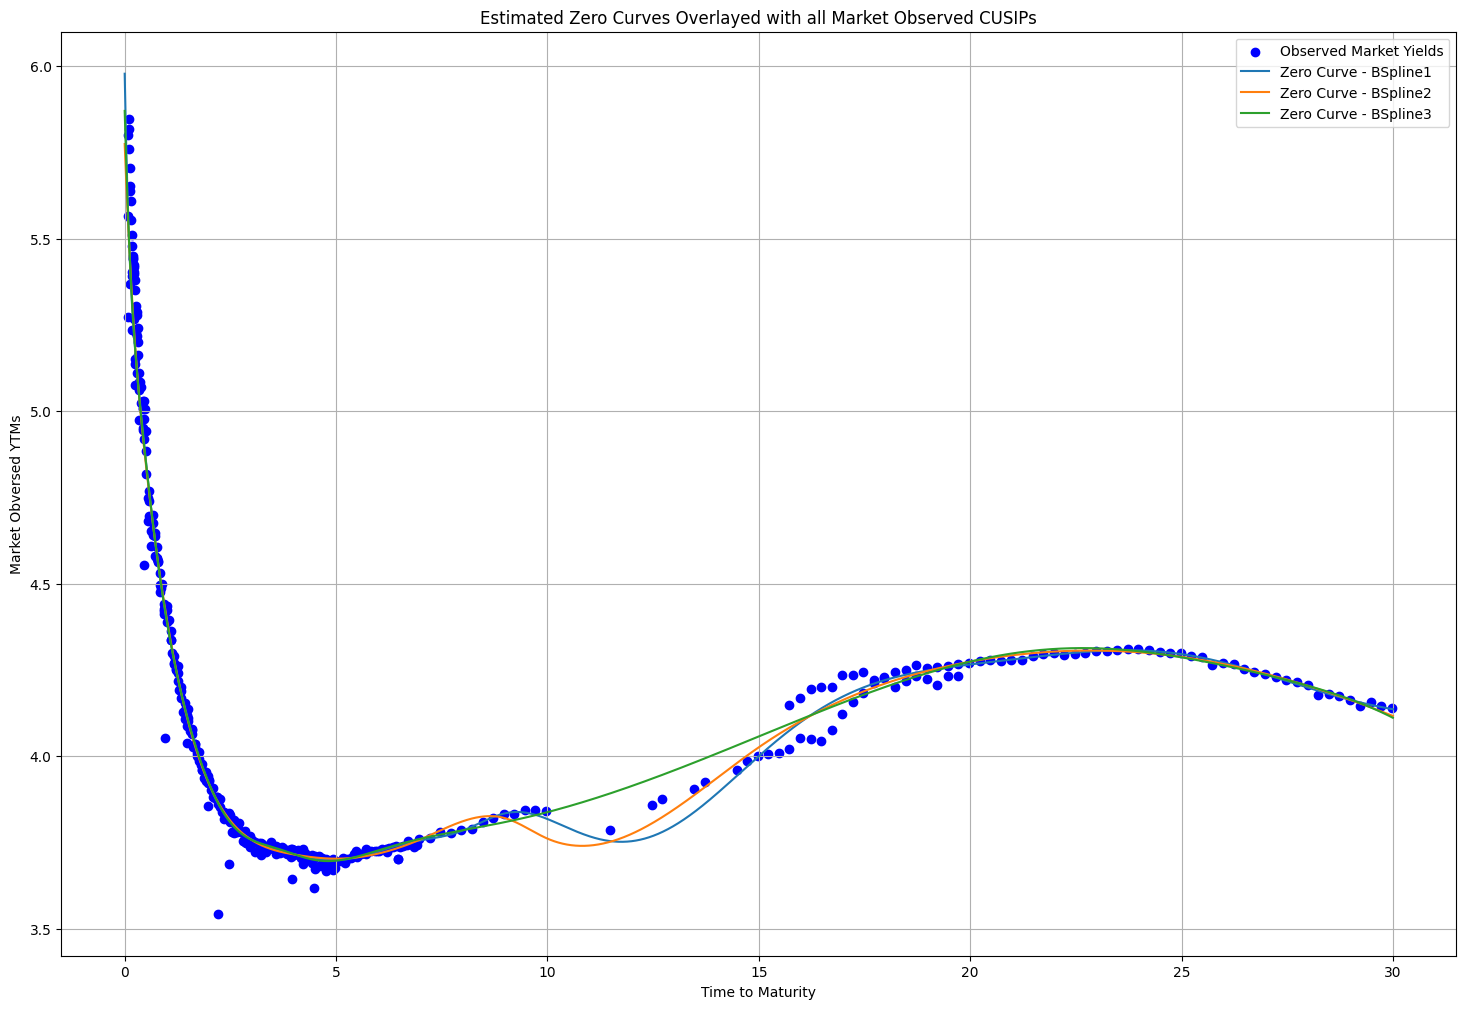

In [137]:
plt.figure(figsize=(18, 12))
plt.scatter(
    curve_set_df[curve_set_df["time_to_maturity"] > 30 / 360]["time_to_maturity"],
    curve_set_df[curve_set_df["time_to_maturity"] > 30 / 360][f"{quote_type}_yield"],
    color="blue",
    label="Observed Market Yields",
)

t2 = np.linspace(0, 30, 10000)

# filtered_curve_set_ns_func, status_ns = calibrate_ns_ols(
#     filtered_curve_set_df["time_to_maturity"].to_numpy(),
#     filtered_curve_set_df[f"{quote_type}_yield"].to_numpy(),
# )
# plt.plot(
#     t2,
#     filtered_curve_set_ns_func(t2),
#     color="orange",
#     label="Zero Curve - NS OLS-Based-Calibration",
# )

# filtered_curve_set_nss_func, status_nss, _ = calibrate_nss_ols(
#     filtered_curve_set_df["time_to_maturity"].to_numpy(),
#     filtered_curve_set_df[f"{quote_type}_yield"].to_numpy(),
# )
# plt.plot(
#     t2,
#     filtered_curve_set_nss_func(t2),
#     label="Zero Curve - NSS OLS-Based-Calibration",
# )

# filtered_curve_set_bc_func, status_bc = calibrate_bc_ols(
#     filtered_curve_set_df["time_to_maturity"].to_numpy(),
#     filtered_curve_set_df[f"{quote_type}_yield"].to_numpy(),
# )
# plt.plot(
#     t2,
#     filtered_curve_set_bc_func(t2),
#     color="green",
#     label="Zero Curve - Bjork Christensen OLS-Based-Calibration",
# )

# filtered_curve_set_aug_bc_func, status_aug_bc = calibrate_bc_augmented_ols(
#     np.concatenate(
#         (np.array([1 / 365]), filtered_curve_set_df["time_to_maturity"].to_numpy())
#     ),
#     np.concatenate(
#         (np.array([5.31]), filtered_curve_set_df[f"{quote_type}_yield"].to_numpy())
#     ),
# )
# plt.plot(
#     t2,
#     filtered_curve_set_aug_bc_func(t2),
#     color="cyan",
#     label="Zero Curve - Augmented Bjork Christensen OLS-Based-Calibration",
# )

# filtered_curve_set_mles_func, status_mles = calibrate_mles_ols(
#     filtered_curve_set_df["time_to_maturity"].to_numpy(),
#     filtered_curve_set_df[f"{quote_type}_yield"].to_numpy(),
#     overnight_rate=5.31,
#     N=6,
# )
# plt.plot(
#     t2,
#     filtered_curve_set_mles_func(t2),
#     color="purple",
#     label="Zero Curve - MLES OLS-Based-Calibration",
# )

curve_interpolater = GeneralCurveInterpolator(
    x=filtered_curve_set_df["time_to_maturity"].to_numpy(),
    y=filtered_curve_set_df[f"{quote_type}_yield"].to_numpy(),
)
bspline_func1 = curve_interpolater.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 20, 25], k=5, return_func=True
)
bspline_func2 = curve_interpolater.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 3, 4, 5, 7, 9, 10, 15, 20, 25], k=3, return_func=True
)
bspline_func3 = curve_interpolater.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 3, 4, 5, 7, 10, 20, 25], k=4, return_func=True
)
# cubic_spline_func1 = curve_interpolater.univariate_spline(s=0.15, return_func=True)
# cubic_spline_func2 = curve_interpolater.univariate_spline(s=0.95, return_func=True)
plt.plot(
    t2,
    bspline_func1(t2),
    label="Zero Curve - BSpline1",
)
plt.plot(
    t2,
    bspline_func2(t2),
    label="Zero Curve - BSpline2",
)
plt.plot(
    t2,
    bspline_func3(t2),
    label="Zero Curve - BSpline3",
)
# plt.plot(
#     t2,
#     cubic_spline_func1(t2),
#     label="Zero Curve - Univariate (Cubic) 1",
# )
# plt.plot(
#     t2,
#     cubic_spline_func2(t2),
#     label="Zero Curve - Univariate (Cubic) 2",
# )

plt.xlabel("Time to Maturity")
plt.ylabel("Market Obversed YTMs")
plt.title("Estimated Zero Curves Overlayed with all Market Observed CUSIPs")
plt.legend()
plt.grid(True)
plt.show()

In [138]:
def par_bond_equation(c, maturity, zero_curve_func):
    discounted_cash_flows = sum(
        (c / 2) * np.exp(-(zero_curve_func(t) / 100) * t)
        for t in np.arange(0.5, maturity + 0.5, 0.5)
    )
    final_payment = 100 * np.exp(-(zero_curve_func(maturity) / 100) * maturity)
    return discounted_cash_flows + final_payment - 100

In [139]:
def par_curve_func(tenor, zero_curve_func):
    init_guess = 4
    return newton(par_bond_equation, x0=init_guess, args=(tenor, zero_curve_func))

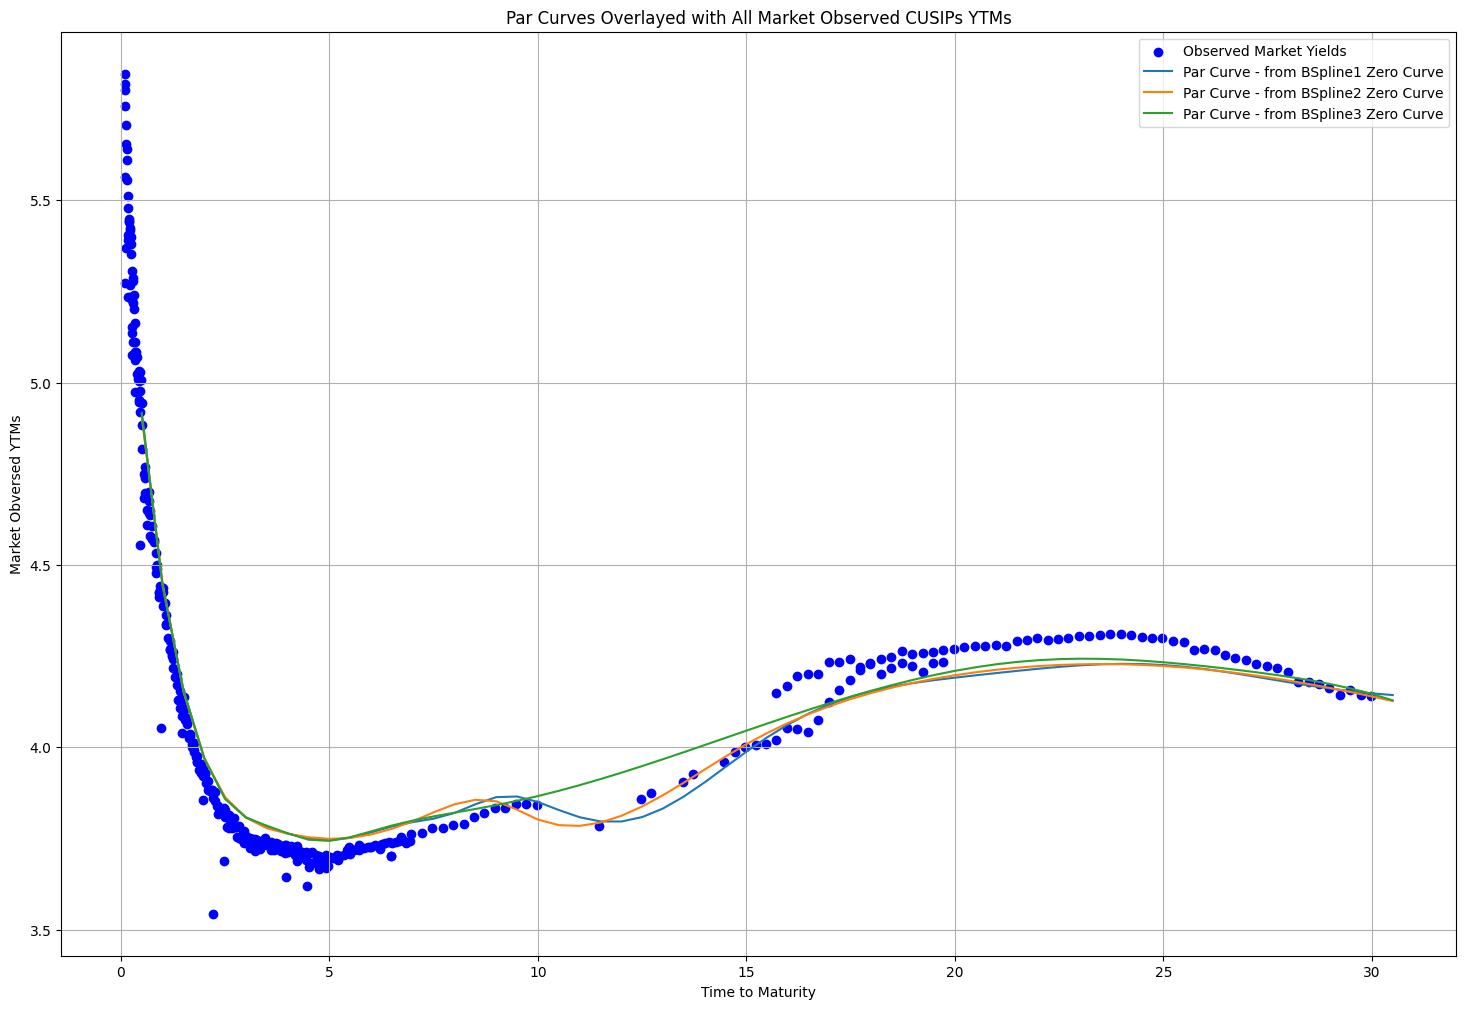

In [141]:
plt.figure(figsize=(18, 12))
plt.scatter(
    curve_set_df[curve_set_df["time_to_maturity"] > 30/360]["time_to_maturity"],
    curve_set_df[curve_set_df["time_to_maturity"] > 30/360][f"{quote_type}_yield"],
    color="blue",
    label="Observed Market Yields",
)

t2 = np.arange(0.5, 30 + 1, 0.5)
# plt.plot(t2, [par_curve_func(t, filtered_curve_set_ns_func) for t in t2], label="Par Curve - from NS Zero Curve")
# plt.plot(t2, [par_curve_func(t, filtered_curve_set_nss_func) for t in t2], label="Par Curve - from NSS Zero Curve")
# plt.plot(t2, [par_curve_func(t, cubic_spline_func1) for t in t2], label="Par Curve - from Cubic1 Zero Curve")
# plt.plot(t2, [par_curve_func(t, cubic_spline_func2) for t in t2], label="Par Curve - from Cubic2 Zero Curve")
plt.plot(t2, [par_curve_func(t, bspline_func1) for t in t2], label="Par Curve - from BSpline1 Zero Curve")
plt.plot(t2, [par_curve_func(t, bspline_func2) for t in t2], label="Par Curve - from BSpline2 Zero Curve")
plt.plot(t2, [par_curve_func(t, bspline_func3) for t in t2], label="Par Curve - from BSpline3 Zero Curve")

plt.xlabel("Time to Maturity")
plt.ylabel("Market Obversed YTMs")
plt.title("Par Curves Overlayed with All Market Observed CUSIPs YTMs")
plt.legend()
plt.grid(True)
plt.show()

In [167]:
import numpy as np

def compute_condition_lower_bound(f, xs, dxs):
    condition_numbers = []
    
    for x in xs:
        fx = f(x)
        for dx in dxs:
            f_x_dx = f(x + dx)
            if fx != 0 and dx != 0:  # Avoid division by zero
                condition_number = abs((f_x_dx - fx) / fx * (x / dx))
                condition_numbers.append(condition_number)
    
    # Return the minimum condition number as the lower bound
    cond_lower_bound = min(condition_numbers)
    return cond_lower_bound

# Example usage
# Define a function f(x)
def f(x):
    return np.sin(x)

# Define input values and perturbations
xs = np.array([1, 2, 3])
dxs = np.array([0.01, 0.001, 0.0001])

# Compute the approximate lower bound for the condition number
cond_lower_bound = compute_condition_lower_bound(f, xs, dxs)
cond_lower_bound


(3, 4, 7, 10)